### Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Обозначения признаков

* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд,
* PaperlessBilling – безналичный расчет,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время
звонка

### Цель проекта
Выбрать модель для прогнозирования оттока клиентов, у которой AUC-ROC >= 0.85 и наибольшая accuracy.

### План проекта
#### 1. Загрузка библиотек и разведывательный анализ данных
- Импорт библиотек
- Просмотр краткой информации по датасетам
- Проверка соблюдения единого стиля в наименованиях столбцов
- Проверка соответствия типов данных реальным значениям
- Выявление наличия / отсутствия пропусков и явных дубликатов в данных

#### 2. Предобработка и исследовательский анализ данных
- Приведение названий столбцов к стилю snake_case
- Объединение таблиц в одну общую по столбцу customerID и обработка появившихся пропусков
- Генерация новых признаков и добавление целевого признака на основе EndDate
- Корректировка типов данных
- Исследовательский анализ данных по лояльным и ушедшим клиентам
- Проверка признаков на мультиколлинеарность
- Определение константы RANDOM_STATE = 240423
- Определение целевого признака и разделение данных на обучающую и тестовую выборки в соотношении 75% / 25%
- Кодирование данных с помощью OneHotEncoder для избежания утечки

#### 3. Обучение и выбор лучшей модели
- Обучение и подбор оптимальных гиперпараметров на кросс-валидации для логистической регрессии, случайного леса и градиентного бустинга
- Сравнение полученных результатов AUC-ROC и accuracy
- Выбор модели по лучшим показателям

#### 4. Проверка выбранной модели на тестовом наборе данных
- Проверка качества модели на тестовом наборе данных
- Проверка на адекватность с помощью константной модели

#### 5. Итоговый вывод
- Описание проделанной работы
- Рекомендация для оператора связи «Ниединогоразрыва.ком»

## Загрузка библиотек и разведывательный анализ данных

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 1.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# общие библиотеки
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from phik.report import plot_correlation_matrix

# метрики и методы sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

# модели sklearn
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

warnings.filterwarnings('ignore')

In [3]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [4]:
data_list = [contract, personal, internet, phone]
names_list = ['contract', 'personal', 'internet', 'phone']

for i, df in enumerate(data_list):
    print(f'Таблица {names_list[i]}')
    print()
    display(df.info())
    display(df.duplicated().sum())
    display(df.head())
    display(df.describe(include='all').T)
    print()
    if i < len(data_list) - 1:
        print('_' * 100)
        print()

Таблица contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

0

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,6185-TASNN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN



____________________________________________________________________________________________________

Таблица personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

0

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,6185-TASNN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN



____________________________________________________________________________________________________

Таблица internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

0

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,count,unique,top,freq
customerID,5517,5517,6185-TASNN,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



____________________________________________________________________________________________________

Таблица phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

0

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,count,unique,top,freq
customerID,6361,6361,6185-TASNN,1
MultipleLines,6361,2,No,3390


In [5]:
display(max(contract['BeginDate']))

'2020-02-01'

### ✅ Вывод:
* Мы получили 7043 наблюдений, из которых можно отметить, что 5517 пользователей пользуется интернет-услугами и 6361 телефонией
* Более половины признаков с бинарными данными
* Названия столбцов записаны в разных стилях, в основном CamelCase, нужно привести к единому стилю snake_case
* Наблюдаются неявные пропуски
* Явные дубликаты отсутствуют
* В таблице contract поле BeginDate стоит привести к типу datetime, поле TotalCharges заполнить заглушкой и привести к типу float
* Последней датой начала договора является 2020-02-01, значит датасет был выгружен в данный день

## Предобработка и исследовательский анализ данных

### Приведение названий столбцов к стилю snake_case

In [6]:
def camel_to_snake(column_name):
    ''' приводит строки к стилю snake_case и добавляет перед большой буквой символ подчеркивания
    (?<!^) проверка на начало строки
    (?=[A-Z]) находит любую большую букву '''
    return re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()

for df in data_list:
    df.columns = [camel_to_snake(col) for col in df.columns]
    df.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
    if df.equals(internet):
        df.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)
    display(df.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Index(['customer_id', 'multiple_lines'], dtype='object')

Столбцы во всех таблицах переименовались корректно. Теперь сделаем одну общую таблицу с помощью последовательного левого соединения по столбцу customer_id, начиная с таблицы contract, для того, чтобы упростить дальнейшую предобработку и анализ

### Объединение таблиц в одну и обработка пропусков

In [7]:
data = contract.merge(personal, how='left', on='customer_id')
data = data.merge(internet, how='left', on='customer_id')
data = data.merge(phone, how='left', on='customer_id')

# проверим, что никакие столбцы не потерялись за вычетом customer_id из трех таблиц
display(data.shape[1] == contract.shape[1] + personal.shape[1] - 1 + internet.shape[1] - 1 + phone.shape[1] - 1)

# убедимся, что все контракты отобразятся в новой таблице
display(data.shape[0] == contract.shape[0])

# посмотрим информацию по объединенной таблице
display(data.head())

True

True

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Объединение прошло успешно. Видно, что появились пропуски, проверим где именно и выясним причину их появления

In [8]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [9]:
print(f'Пропусков в столбцах с информацией об интернет-услугах: {data.shape[0] - internet.shape[0]}')
print(f'Пропусков в столбцах с информацией о телефонии: {data.shape[0] - phone.shape[0]}')

Пропусков в столбцах с информацией об интернет-услугах: 1526
Пропусков в столбцах с информацией о телефонии: 682


Видим, что пропуски после объединения таблиц появились только в колонках с информацией о дополнительных услугах. Как мы уже отмечали выше, из 7043 контрактов только 5517 пользователей пользуется интернет-услугами и 6361 телефонией, что соответствует образовавшимся пропускам

Все столбцы с информацией о доп.услугах бинарные, содержат значения Yes или No, поэтому пропущенные значения можно заполнить значением **No**, то есть отсутствие доп.услуги

Дополнительно рассмотрим содержимое столбцов  **internet_service** и **multiple_lines**

In [10]:
display(data['internet_service'].value_counts())
display(data['multiple_lines'].value_counts())

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

Наблюдаем два типа подключения к интернету: через телефонную линию (DSL) и оптоволоконный кабель (Fiber optic). Поэтому пропуски также можем заполнить заполнить значением **No**, что будет означать отсутствие подключения

Особое внимание стоит обратить на столбец с пропусками **multiple_lines** – наличие возможности ведения параллельных линий во время звонка. Если клиент не воспользовался услугой телефонии, значит у него по умолчанию нет никаких звонков, поэтому стоит заменить пропущенные значения заглушкой, отличной от Yes или No

In [11]:
columns_miss = ['internet_service', 'online_security', 'online_backup', 'device_protection',
                'tech_support', 'streaming_tv', 'streaming_movies']

for column in columns_miss:
    data[column] = data[column].fillna('No')
    
data['multiple_lines'] = data['multiple_lines'].fillna('Miss')

Теперь перейдем к столбцу total_charges и посмотрим содержимое

In [12]:
display(data['total_charges'].value_counts())

           11
20.45       6
101.0       5
1007.5      4
21.53       4
           ..
245.0       1
1643.54     1
551.57      1
4906.0      1
6181.03     1
Name: total_charges, Length: 6658, dtype: int64

In [13]:
data[data['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Miss
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Miss
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


11 значений с пробелом вместо суммы, все 11 договоров были заключены 2020-02-01, то есть в день выгрузки датасета, поэтому логично, что никаких трат еще не было. Заменим пробелы на 0

In [14]:
data['total_charges'] = data['total_charges'].replace([' '], [0])
data['total_charges'] = data['total_charges'].astype(float)
data['total_charges'] = data['total_charges'].astype(int)
display(data['total_charges'].value_counts())

20      40
19      31
21      21
40      20
44      16
        ..
5858     1
6649     1
1764     1
4596     1
8182     1
Name: total_charges, Length: 3739, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

Все пропущенные значения успешно устранены

### Преобразование бинарных признаков в числовой формат

Теперь для удобства заменим все бинарные признаки на 1 и 0 вместо No / Yes. Оставшиеся категориальные столбцы преобразуем уже после разделения данных

In [16]:
binary_columns = ['paperless_billing', 'partner', 'dependents',
                 'online_security', 'online_backup', 'device_protection',
                 'tech_support', 'streaming_tv', 'streaming_movies']

for column in binary_columns:
    data[column] = data[column].replace(['Yes', 'No'], [1, 0])
    
data['gender'] = data['gender'].replace(['Female', 'Male'], [1, 0])

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,31,1,0,1,0,DSL,0,1,0,0,0,0,Miss
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,2071,0,0,0,0,DSL,1,0,1,0,0,0,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,1,Mailed check,53.85,226,0,0,0,0,DSL,1,1,0,0,0,0,No
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1960,0,0,0,0,DSL,1,0,1,1,0,0,Miss
4,9237-HQITU,2019-09-01,No,Month-to-month,1,Electronic check,70.70,353,1,0,0,0,Fiber optic,0,0,0,0,0,0,No


### Добавление новых признаков

Для избежания утечки данных во время обучения алгоритмов нужно избавиться от признаков с датами начала и окончания договора, но сначала сделаем с их помощью новые признаки

Посмотрим последнюю загруженную дату начала договора и содержимое признака **end_date**, чтобы определить, что должно быть в будущем целевом признаке

In [17]:
display(data['end_date'].value_counts())

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

На основе указанных столбцов с датами сделаем два новых признака: целевой признак и длительность договора в днях.

Так как мы будем решать задачу классификации, а целевым признаком будем информация об актуальности договора, то сделаем следующее:
- В столбце end_date заменим **No** на заглушку-дату 2020-02-01, т.е. дату выгрузки датасета
- Если в столбце end_date стоит дата окончания пользования услугами – значит клиент ушёл (True), заменим даты цифрой 1
- Если же стоит заглушка, то есть отсутствие даты окончания, значит договор еще действующий (False), и вместо заглушки поставим 0

In [18]:
# меняем No на заглушку-дату
data['end_date'] = data['end_date'].replace(['No'], ['2020-02-01']) 
data['end_date'].value_counts()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

In [19]:
''' все строки, которые True (не равны заглушке и означают, что договор расторгнут) 
будут иметь значение 1, а False (действующие договоры) будут равны 0 '''
data['target'] = (data['end_date'] != '2020-02-01') * 1
data['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

Чтобы рассчитать длительность договора, нужно привести оба столбца к формату datetime64 и затем создать новый столбец на основе разницы между датой окончания и датой начала договора

In [20]:
date_column = ['begin_date', 'end_date']
# приводим столбцы к формату datetime64
for col in date_column:
    data[col] = pd.to_datetime(data[col], format = '%Y-%m-%d')
    print(data[col].dtypes)

datetime64[ns]
datetime64[ns]


In [21]:
# используем abs, тк длительность договора не может быть отрицательной
# и преобразуем столбец в int
data['contract_duration'] = abs(data['end_date'] - data['begin_date']).dt.days
data['contract_duration'].value_counts()

2191    265
153     249
92      243
31      236
123     236
       ... 
121       1
2253      1
424       1
1309      1
547       1
Name: contract_duration, Length: 251, dtype: int64

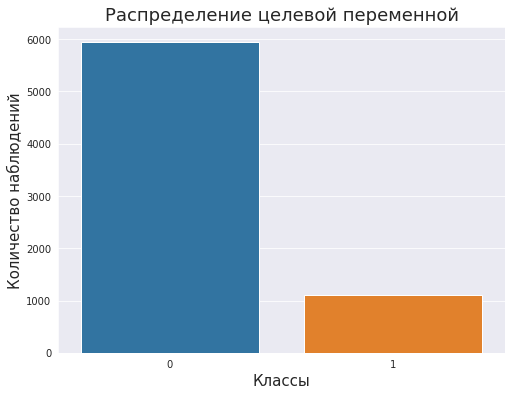

In [22]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'target', data = data, ax = ax)

ax.set_title('Распределение целевой переменной', fontsize = 18)
ax.set_xlabel('Классы', fontsize = 15)
ax.set_ylabel('Количество наблюдений', fontsize = 15)

plt.show();

Наблюдается дисбаланс классов с перевесом в пользу действующих договоров. При обучении алгоритмов решим проблему дисбаланса с помощью параметра **class_weight='balanced'**, который автоматически вычисляет веса классов, пропорциональных количеству наблюдений в каждом классе. Таким образом, класс с меньшим количеством наблюдений, в нашем случае класс 1, будут иметь больший вес, что поможет сбалансировать данные и улучшить качество модели на несбалансированных данных.

С датами разобрались, поэтому можем удалить столбцы begin_date и end_date. Заодно уберем customer_id – при обучении и анализе мультиколлинеарности он ничего нам не даст

In [23]:
data = data.drop(['begin_date', 'end_date', 'customer_id'], axis = 1)
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'target', 'contract_duration'],
      dtype='object')

### Исследовательский анализ по действующим и ушедшим клиентам

Совместим на каждом графике две группы: ушедшие (класс 1) и действующие (класс 0) клиенты, чтобы рассмотреть распределение признаков, возможно, выявить закономерность почему уходили клиенты

In [24]:
def make_histplot(column, title, xlabel):
    plt.figure(figsize=(15, 7))
    sns.histplot(data, x = column, hue = 'target', multiple = 'stack', bins=25)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Количество клиентов', fontsize=15)
    plt.show();

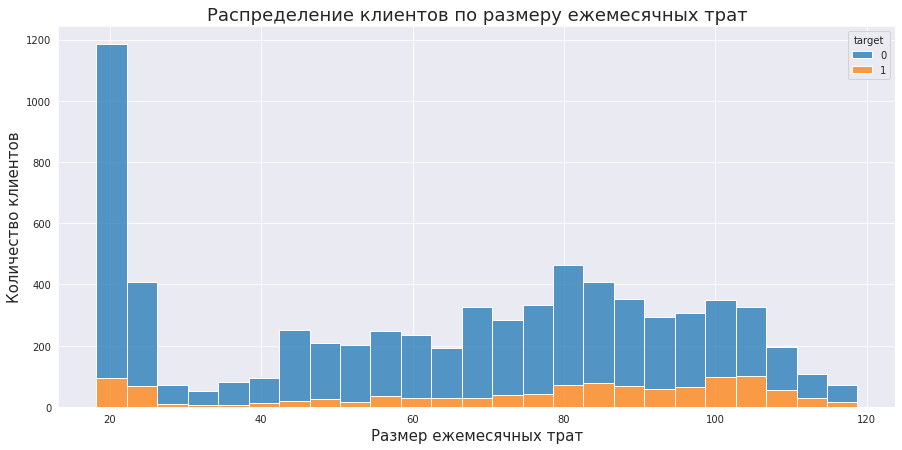

In [25]:
make_histplot('monthly_charges', 
              'Распределение клиентов по размеру ежемесячных трат', 
              'Размер ежемесячных трат')

- Выделяются ушедшие клиенты, которые потратили от 80 до 105 y.e. Возможно они не знали о каких-либо выгодных условиях, и ушли к другому оператору с более дешевыми услугами
- Большое количество действующих клиентов потратили на услуги оператора связи не более 20 y.e., но в целом распределение затрат среди действующих клиентов находится в диапазоне от 40 до 100 y.e.

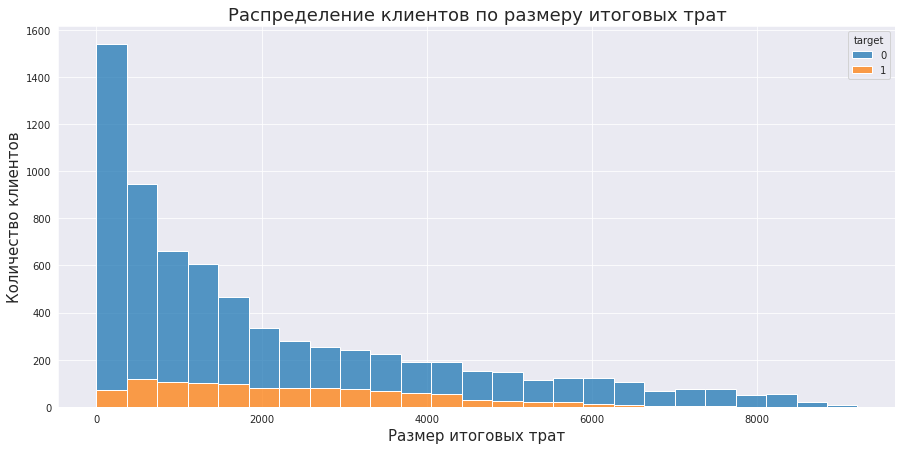

In [26]:
make_histplot('total_charges', 
              'Распределение клиентов по размеру итоговых трат', 
              'Размер итоговых трат')

- Наблюдается пик среди действующих клиентов, скорее всего это недавно заключенные договора, по которым еще не производилась оплата

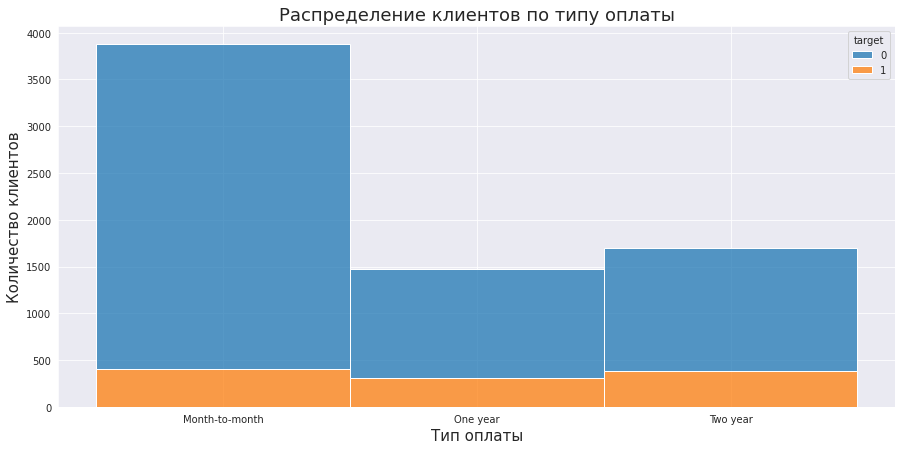

In [27]:
make_histplot('type', 
              'Распределение клиентов по типу оплаты', 
              'Тип оплаты')

- Ушедшие клиенты равномерно распределились по каждой группе, поэтому сказать, что их не устраивал какой-то конкретный тип оплаты нельзя
- Действующие клиенты больше предпочитают ежемесячный тип оплаты

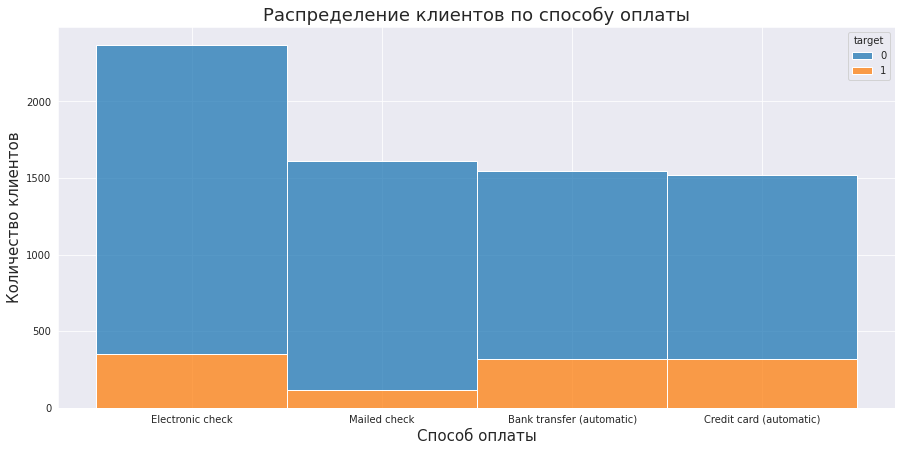

In [28]:
make_histplot('payment_method', 
              'Распределение клиентов по способу оплаты', 
              'Способ оплаты')

- Ушедшие клиенты меньше всего пользовались бумажными чеками, направленными по почте, и в равной мере предпочитали остальные способы
- Действующие клиенты больше предпочитают электронный чек

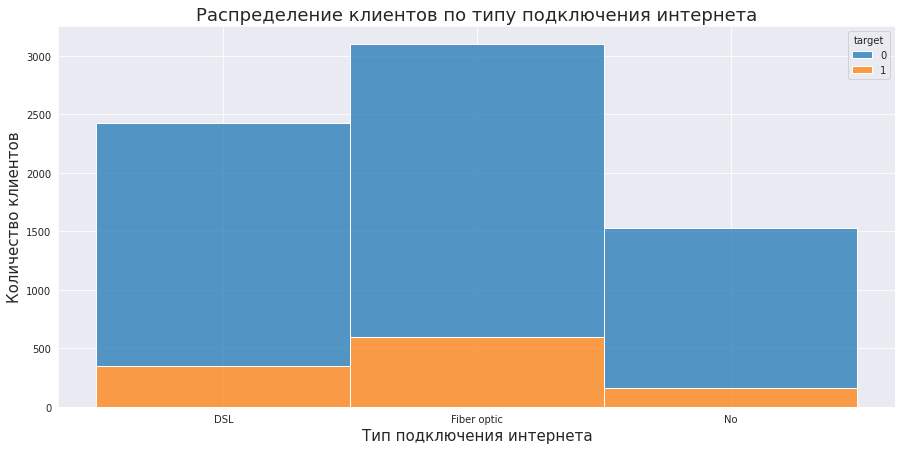

In [29]:
make_histplot('internet_service', 
              'Распределение клиентов по типу подключения интернета', 
              'Тип подключения интернета')

- Большая доля и действующих, и ушедших клиентов предпочитает оптоволоконный кабель, и чуть меньше цифровую линию
- 1500 действующих клиентов не подключали интернет

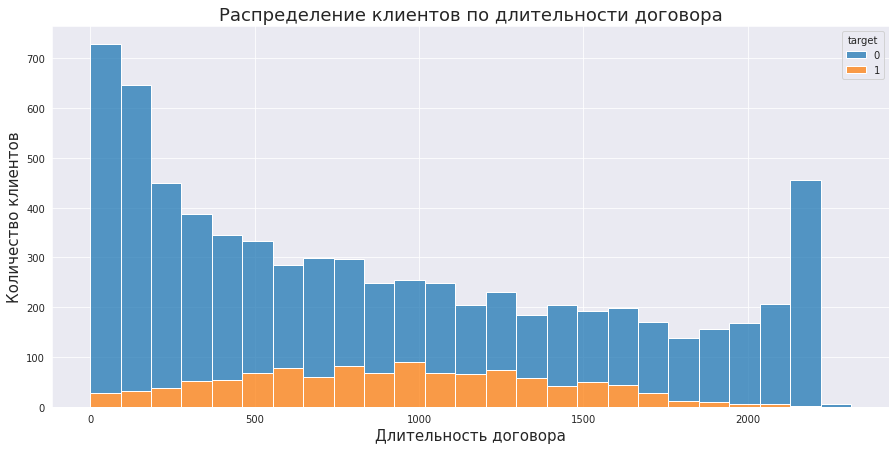

In [30]:
make_histplot('contract_duration', 
              'Распределение клиентов по длительности договора', 
              'Длительность договора')

- Большая часть клиентов уходила в диапазоне с 500 по 1300 дней. Это не маленький срок, скорее всего, клиенты находили более выгодные для себя варианты, которые текущий оператор не предлагал
- Отмечается резкий пик среди новых действующих клиентов, и среди старожилов (более 2000 дней)

### Проверка признаков на мультиколлинеарность

In [31]:
interval_cols = ['monthly_charges', 'contract_duration']

phik_overview = data.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_duration
type,1.00,0.11,0.28,0.39,0.74,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.24,0.09,0.63
paperless_billing,0.11,1.00,0.37,0.47,0.16,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.10,0.08,0.03
payment_method,0.28,0.37,1.00,0.40,0.50,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.17,0.21,0.35
monthly_charges,0.39,0.47,0.40,1.00,0.82,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.71,0.23,0.39
total_charges,0.74,0.16,0.50,0.82,1.00,0.01,0.47,0.42,0.26,0.56,0.70,0.72,0.75,0.71,0.70,0.72,0.58,0.57,0.93
gender,0.00,0.00,0.00,0.01,0.01,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00
senior_citizen,0.09,0.24,0.29,0.30,0.47,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.09,0.09,0.06
partner,0.18,0.01,0.24,0.20,0.42,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.09,0.23,0.45
dependents,0.15,0.17,0.22,0.18,0.26,0.00,0.32,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.01,0.05,0.20
internet_service,0.51,0.23,0.32,0.92,0.56,0.00,0.16,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.74,0.06,0.06


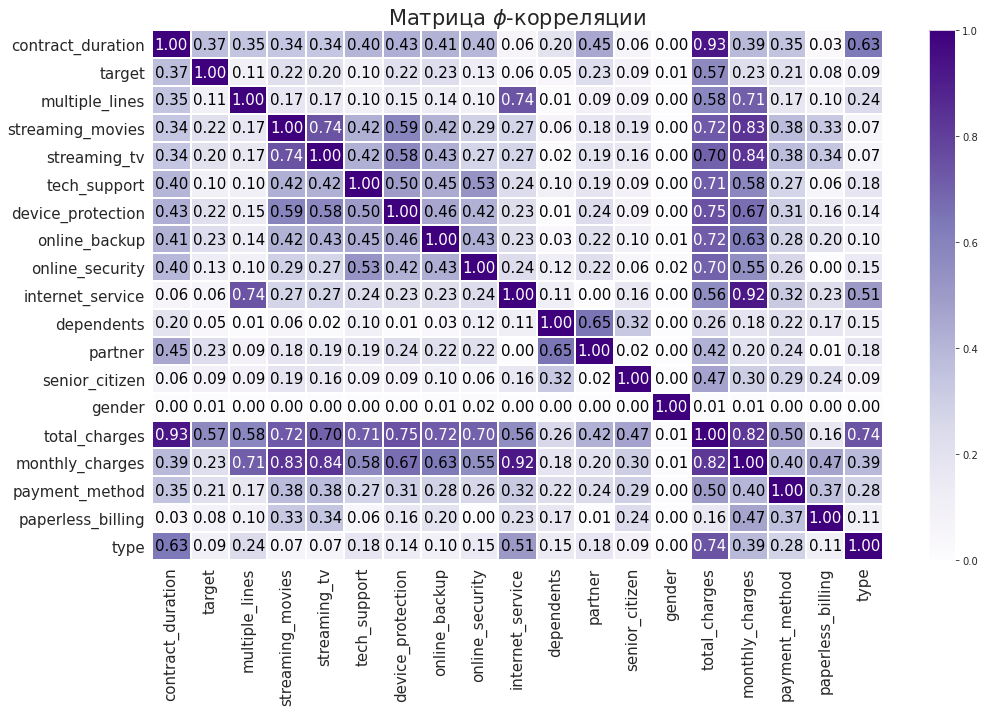

In [32]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels = phik_overview.columns, 
                        y_labels = phik_overview.index, 
                        vmin = 0, vmax = 1, color_map = 'Purples', 
                        title = r"Матрица $\phi$-корреляции", 
                        fontsize_factor = 1.5, 
                        figsize = (15, 10))
plt.tight_layout()

- С целевым признаком больше всех коррелирует новый признак длительность договора (contract_duration)
- Заметна коррелляция у monthly_charges (ежемесячные траты на услуги) и total_charges (всего потрачено денег на услуги) с различными дополнительными услугами, что вполне логично, есть траты на доп.услуги – есть зависимость
- Можно также отметить 0.65 корреляции при наличии супруга (partner) с наличием иждивенцев (dependents) – у многих людей в браке есть дети, которые являются иждивенцами
- Признаки monthly_charges и total_charges также коррелируют между собой (0.71), что тоже объяснимо: растут ежемесячные траты – растет и общее количество расходов. Для обучения стоит оставить только один признак, оставим ежемесячные траты

In [33]:
data = data.drop(['total_charges'], axis = 1)
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'target',
       'contract_duration'],
      dtype='object')

### Разделение и кодирование данных

In [34]:
RANDOM_STATE = 240423

In [35]:
features = data.drop('target', axis=1)
target = data['target']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.25,
                                                                            random_state = RANDOM_STATE,
                                                                            stratify = target)

# проверим, что ничего не потеряли
data.shape[0] == features_train.shape[0] + features_test.shape[0]

True

#### Подготовка данных для логистической регрессии и случайного леса

Применим прямое кодирование get_dummies, так как у нас осталось мало категориальных признаков

In [36]:
# закодируем категориальные признаки
features_train_ohe = pd.get_dummies(features_train, drop_first = True)
features_test_ohe = pd.get_dummies(features_test, drop_first = True)

# проверим, что ничего не потеряли
display(data.shape[0] == features_train_ohe.shape[0] + features_test_ohe.shape[0])
display(features_train_ohe.columns == features_test_ohe.columns)

display(features_train_ohe.head(2))
display(features_test_ohe.head(2))

True

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

,paperless_billing,monthly_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,contract_duration,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,multiple_lines_No,multiple_lines_Yes
288,1,74.50,0,1,0,0,0,1,0,0,...,365,0,0,0,1,0,1,0,1,0
199,0,20.75,0,0,0,1,0,0,0,0,...,31,0,0,0,0,1,0,1,1,0


,paperless_billing,monthly_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,contract_duration,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,multiple_lines_No,multiple_lines_Yes
5454,1,69.55,1,1,1,0,0,0,0,0,...,123,0,0,0,1,0,1,0,1,0
4489,1,53.85,1,0,1,1,0,1,0,0,...,1949,1,0,0,0,0,0,0,0,1


#### Подготовка данных для модели LightGBM

Для повышения производительности и ускорения обучения модели LightGBM преобразуем категориальные признаки из object в category

In [37]:
# отбираем категориальные признаки
categorical = features_train.dtypes[features_train.dtypes == 'object'].index

# преобразовываем в тип 'category'
features_train[categorical] = (features_train[categorical].astype('category'))
features_test[categorical] = (features_test[categorical].astype('category'))

# проверяем
print(features_train.dtypes)
print('-' * 50)
print(features_test.dtypes)

type                 category
paperless_billing       int64
payment_method       category
monthly_charges       float64
gender                  int64
senior_citizen          int64
partner                 int64
dependents              int64
internet_service     category
online_security         int64
online_backup           int64
device_protection       int64
tech_support            int64
streaming_tv            int64
streaming_movies        int64
multiple_lines       category
contract_duration       int64
dtype: object
--------------------------------------------------
type                 category
paperless_billing       int64
payment_method       category
monthly_charges       float64
gender                  int64
senior_citizen          int64
partner                 int64
dependents              int64
internet_service     category
online_security         int64
online_backup           int64
device_protection       int64
tech_support            int64
streaming_tv            int64
strea

## Обучение моделей

In [38]:
CV = 5

In [39]:
# создадим функцию для кросс-валидации

roc_auc_list = []
accuracy_list = []
models_list = []

def make_rs(model, parameters, features_train, target_train):
    
    scoring = {'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}
    
    model = RandomizedSearchCV(model,
                               parameters,
                               random_state = RANDOM_STATE,
                               cv = CV,
                               scoring = scoring,
                               refit = 'roc_auc',
                               n_jobs = -1)
    
    model.fit(features_train, target_train)
    
    roc_auc_value = round(model.cv_results_['mean_test_roc_auc'][model.best_index_], 2)
    accuracy_value = round(model.cv_results_['mean_test_accuracy'][model.best_index_], 2)
    
    roc_auc_list.append(roc_auc_value)
    accuracy_list.append(accuracy_value)
    models_list.append(model.best_estimator_)
    
    print(model.best_params_)
    print(f'ROC-AUC: {roc_auc_value:.2f}')
    print(f'Accuracy: {accuracy_value:.2f}')
    print()

### Логистическая регрессия

In [40]:
%%time

model_lr = LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced')

parameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

make_rs(model_lr, parameters, features_train_ohe, target_train)

{'solver': 'liblinear', 'penalty': 'l1', 'fit_intercept': True, 'C': 10}
ROC-AUC: 0.76
Accuracy: 0.70

CPU times: user 15.1 s, sys: 8 s, total: 23.1 s
Wall time: 23.2 s


### Случайный лес

In [41]:
%%time

model_rf = RandomForestClassifier(random_state = RANDOM_STATE, class_weight = 'balanced')

parameters = {
    'max_depth': [2, 7],
    'n_estimators': [150, 300, 450, 500],
    'max_features': [5, 7, 9],
    'min_samples_leaf': [3, 4, 6],
    'min_samples_split': [2, 3, 4],
    'criterion': ['gini','entropy']
}

make_rs(model_rf, parameters, features_train_ohe, target_train)

{'n_estimators': 450, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 9, 'max_depth': 7, 'criterion': 'entropy'}
ROC-AUC: 0.83
Accuracy: 0.77

CPU times: user 53 s, sys: 22.7 ms, total: 53 s
Wall time: 53 s


### LightGBM

In [ ]:
%%time

model_lgbm = LGBMClassifier(random_state = RANDOM_STATE, class_weight = 'balanced')

parameters = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'learning_rate': [0.05, 0.01, 0.1, 0.5],
    'max_depth': [10, 20, 50, 100],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.5]
}

make_rs(model_lgbm, parameters, features_train, target_train)

[LightGBM] [Warning] Unknown parameter: gamma


### Сравнение полученных результатов AUC-ROC и accuracy, выбор лучшей модели

In [ ]:
# проверим, что лучшие параметры моделей сохранились корректно
models_list

In [ ]:
compare = pd.DataFrame(
    {'Значение ROC auc': roc_auc_list,
     'Значение accuracy': accuracy_list},
    index = ['Логистическая регрессия', 'Случайный лес', 'LightGBM']
)

compare

Лучшие показатели по всем фронтам показала модель градиентного бустинга LightGBM

## Проверка качества модели на тестовом наборе данных

In [ ]:
test_model_lgbm = models_list[2]

test_model_lgbm.fit(features_train, target_train)
predictions = test_model_lgbm.predict(features_test)

probabilities = test_model_lgbm.predict_proba(features_test)[:, 1]  # вероятности для класса 1

roc_auc = roc_auc_score(target_test, probabilities)
accuracy = accuracy_score(target_test, predictions)

print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Точность предсказаний и AUC-ROC равны 0.89 – мы смогли перейти обозначенную границу AUC-ROC >= 0.85 и добились указанной цели

Рассмотрим график ROC-кривой, который поможет оценить качество бинарной классификации

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.title('Визуализация ROC-кривой', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.show();

Чем больше кривая ROC охватывает верхний левый угол графика и чем больше площадь под кривой, тем лучше модель классифицирует данные по категориям. У нашей модели AUC-ROC получился 0.89, а сама кривая близко к левому верхнему углу, что говорит о хорошей способности к различению 1 и 0 классов

In [ ]:
c_matrix = confusion_matrix(target_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(c_matrix,
            annot=True,
            cmap='gist_earth',
            fmt='d')
plt.title('Матрица ошибок', fontsize=16)
plt.show();

Модель LightGBM сделала 1407 правильных предсказаний для класса 0 и 164 для класса 1. Это прекрасный результат с учетом того, что данных для 1 класса у нас не хватает

Проверим какие признаки были полезны для выбранной модели и помогли добиться хороших показателей:

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
plot_importance(test_model_lgbm, ax=ax)
plt.show();

Двумя основными признаками, влияющими на отток клиентов являются длительность договора и ежемесячные траты. Чем дольше клиент пользуется выбранным оператором связи и больше тратит денежных средств на его услуги, тем меньше вероятность того, что он уйдет

Также больше остальных имеет значение признак тип оплаты: если тип оплаты не подходит – клиенты ищут что-то более удобное

Можно сделать вывод, что остальные признаки не внесли большего вклада в предсказания модели, и без них в дальнейшем можно обойтись, оставив их для статистики

## Проверка на адекватность с помощью константной модели

In [ ]:
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(features_train, target_train)
dummy_pred = dummy_model.predict(features_test)

dummy_roc_auc = roc_auc_score(target_test, dummy_pred)
dummy_accuracy = accuracy_score(target_test, dummy_pred)

print(f'ROC-AUC: {dummy_roc_auc:.2f}')
print(f'Accuracy: {dummy_accuracy:.2f}')

У константной модели показатели значительно хуже. ROC-AUC: 0.51 означает, что модель плохо различает классы и практически ничем не отличается от случайного классификатора. Поэтому выбранная нами модель LightGBM успешно прошла проверку

## Итоговый вывод

На рассмотрение было предложено 4 датасета с информацией, полученной из разных источников:
информация о договоре, персональные данные клиента, информация об интернет-услугах и информация об услугах телефонии. Нами было принято решение объединить все данные в одну таблицу для упрощения проведения предобработки данных и анализа.
На этапе предобработки мы: 
- Привели названия стобцов к единому стилю
- Добавили два новых признака: целевой и длительность договора
- Проверили данные на мультиколлинеарность и приняли решение избавиться от столбцов с датами и убрать один столбец с тратами
- Разделили данные на обучающие и тестовые, и подготовили наборы индивидуально для каждого алгоритма
- Обучили и подобрали оптимальные гиперпараметры с помощью кросс-валидации для логистической регрессии, случайного леса и градиентного бустинга, сравнили полученные метрики
- Проверили лучшую модель на качество при работе с тестовыми данными и адекватность при сравнении с константной моделью

Выбранная модель LightGBM смогла получить AUC-ROC >= 0.85 и наибольшую accuracy на обучающих и тестовых данных

📌 По итогам проведенной работы, оператору связи «Ниединогоразрыва.ком» для прогнозирования оттока клиентов стоит порекомендовать модель градиентного бустинга LightGBM с гиперпараметрами class_weight='balanced', gamma=0.1, learning_rate=0.5, max_depth=50, random_state=240423, reg_lambda=0.5

📌 Большая часть клиентов уходила в диапазоне с 500 по 1300 дней. На них стоит обратить внимание и предлагать какие-либо акции и скидки на доп.услуги

📌 Также компании «Ниединогоразрыва.ком» стоит провести опрос среди лояльных и будущих клиентов по типу оплаты, так как текущий выбор подходит не всем клиентам, и, возможно, будет полезным добавить новый тип или оптимизировать текущие

## Отчет

Перед тем как приступить к исследованию, мы составили пошаговый план действий для каждого этапа. План состоит из 5 пунктов и большого количества подпунктов.

↪ Первым делом мы импортировали все необходимые библиотеки и провели первичный (разведывательный) анализ данных, чтобы понять какие данные мы получили на вход и какую полезную информацию мы из них можем извлечь. В ходе первого этапа мы определили, что у нас есть 4 таблицы с информацией из разных источников с актуальностью на 2020-02-01: информация о договоре, персональные данные клиента, информация об интернет-услугах и информация об услугах телефонии. Всего получено 7043 уникальных наблюдений-договоров. От заказчика мы получили подробное описание столбцов в указанных таблицах, поэтому никаких проблем с идентификацией данных на текущем этапе не возникло. На этом этапе мы определили необходимые действия для второго этапа.

↪ Второй этап стал самым объемным в нашем исследовании, были проделаны следующие ключевые мероприятия:
- предобработка данных и объединение таблиц в одну общую по столбцу customer_id
- создание нового признака длительность договора contract_duration, который в последствии оказал большое влияние на обучение и качество модели, и целевой признак target
- проведение исследовательского анализа данных по лояльным и ушедшим клиентам
- проверка признаков на мультиколлинеарность, в ходе которой было принято решение избавиться от одного из признаков с тратами (total_charges) из-за корреляции с другим признаком
- обозначение константы RANDOM_STATE = 240423 и разделение данных на обучающую и тестовую выборки в соотношении 75% / 25% и кодирование данных OHE для избежания утечки

В ходе работы с данными трудностей не возникало. Все этапы были одинаково полезны, без какого либо из них мы бы не смогли добиться поставленной цели. Нам удалось придерживаться первоначального плана без отклонений

📌 По итогам третьего и четвертого этапа была выявлена лучшая модель: LightGBM, которая смогла получить AUC-ROC >= 0.85 и наибольшую accuracy на обучающих и тестовых данных, а именно ROC AUC – 0.89 на тесте, с гиперпараметрами class_weight='balanced', gamma=0.1, learning_rate=0.5, max_depth=50, random_state=240423, reg_lambda=0.5, которая обучалась на всех признаках, кроме: begin_date, end_date, customer_id и  total_charges. Подробнее список признаков, на которых обучалась модель можно рассмотреть ниже:

In [ ]:
features_train.columns